In [1]:
%run '/home/gvolta/Desktop/Function/Useful/Def.ipynb'

Initialization done, Notebook was last run on: 17/07/2019


In [2]:
import lax 
from lax.lichens import sciencerun1
from lax.lichens import sciencerun0
from lax.lichens import postsr1

In [3]:
from pax import units, configuration
pax_config = configuration.load_configuration('XENON1T')['DEFAULT']
tpc_height = pax_config['tpc_length']
tpc_radius = pax_config['tpc_radius']

import hax
hax.init(experiment='XENON1T',
         pax_version_policy = 'v6.10.1',
         main_data_paths= ['/dali/lgrandi/xenon1t/processed/pax_v6.10.1'], 
         minitree_paths = ['/dali/lgrandi/giovo/minitrees/pax_v6.10.1',
                           '/dali/lgrandi/xenon1t/minitrees/pax_v6.10.1'],
         make_minitrees = False)

%matplotlib inline

In [4]:
dali_path = '/dali/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/'
project_path = '/project/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/'

No pre-selsction applye to the follow dataframe.
- /project/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/Rn_1_SR1_S1PL.haxcache -> First data sample 
- /project/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/Rn_2_SR1_S1PL.haxcache -> Second data sample 
- /project/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/Rn_3_SR1_S1PL.haxcache -> Thirsd data sample 
- /project/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/NG_SR1_S1PL.haxcache   -> Neutron Generator data

For S2PatternLikelihood cut:
- (project_path + 'Rn_1_SR1_S1PL.haxcache') + (project_path + 'Rn_1_S2PatternReducedAP.haxcache') -> First Rn data sample without cut
- (project_path + 'Rn_2_SR1_S1PL.haxcache') + (project_path + 'Rn_2_S2PatternReducedAP.haxcache') -> Second Rn data sample without cut
- (project_path + 'Rn_3_SR1_S1PL.haxcache') + (project_path + 'Rn_3_S2PatternReducedAP.haxcache') -> Third Rn data sample without cut
- (project_path + 'NG_SR1_S1PL.haxcache') + (project_path + 'NG_S2PatternReducedAP.haxcache') -> NG data sample without cut

## Selection

- Z in [-83.45, -13.45] cm and r < 39.85 cm for fiducialization
- s1_pattern_fit =! NaN
- S2 =! NaN
- CS2AFT_Extended
- CutS2Threshold 
- CutInteractionsPeaksBiggest
- CutS2Width
- CutS2SingleScatterHE

In [5]:
# Tianyu new S2Singlescatter cut
import pickle
with open('/project2/lgrandi/zhut/s2_single_classifier_gmix_v6.10.0.pkl', 'rb') as f:
    gmix=pickle.load(f)

def classify(df):
    df['CutS2SingleScatterHE'] = 0

    mask = df.eval('(largest_other_s2>0) & (s2>0) & (largest_other_s2_pattern_fit>0) \
    ')
    Y = np.concatenate([np.log10(df.loc[mask,['largest_other_s2', 'largest_other_s2_pattern_fit', 's2']]),
                    ],
                   axis=1)
    df.loc[mask,'CutS2SingleScatterHE'] = gmix.predict(Y)
    df.loc[:, 'CutS2SingleScatterHE'] = np.array(df.CutS2SingleScatterHE, bool)
    return df

CutS2Threshold = sciencerun1.S2Threshold()
CS2AFT_Extended = postsr1.CS2AreaFractionTopExtended()
CutInteractionsPeaksBiggest = sciencerun1.InteractionPeaksBiggest()
CutS2Width = sciencerun1.S2Width()
CutDAQVeto = sciencerun1.DAQVeto()
CutFlash = sciencerun1.Flash()

import sys
sys.path.insert(0, '/home/gvolta/Desktop/SR1/S1PatternLikelihoodExtended/S2PatternLikelihood')
# Chloe new S2PatternLikelihood cut
from S2PatternReducedAP import S2PatternReducedAP
from Apply_S2PatternLikelihoodCut_HE_r_phi import S2PatternLikelihood_HE

### Opening data

In [6]:
file1 = project_path + 'Rn_1_SR1_S1PL.haxcache'
data1 = hax.minitrees.load_cache_file(file1)

data1['CutFiducialization'] = (data1['z_3d_nn_tf'] < -13.45)&(data1['z_3d_nn_tf'] > -83.45)&(data1['r_3d_nn_tf'] < 39.85)
data1 = hax.cuts.selection(data1, data1['CutFiducialization'] == True)

data1 = classify(data1)
data1 = hax.cuts.selection(data1, data1['CutS2SingleScatterHE'] == True)

data1 = CutS2Threshold.process(data1)
data1 = hax.cuts.selection(data1, data1['CutS2Threshold'] == True)

data1 = CS2AFT_Extended.process(data1)
data1 = hax.cuts.selection(data1, data1['CutCS2AreaFractionTopExtended'] == True)

data1 = CutInteractionsPeaksBiggest.process(data1)
data1 = hax.cuts.selection(data1, data1['CutInteractionPeaksBiggest'] == True)

data1 = CutS2Width.process(data1)
data1 = hax.cuts.selection(data1, data1['CutS2Width'] == True)

data1['CutS1PatternFitExist'] = np.isnan(data1['s1_pattern_fit'])
data1['CutCS2bExist'] = np.isnan(data1['cs2_bottom_nn_tf'])
data1 = hax.cuts.selection(data1, data1['CutS1PatternFitExist'] == False)
data1 = hax.cuts.selection(data1, data1['CutCS2bExist'] == False)

data1 = CutDAQVeto.process(data1)
data1 = hax.cuts.selection(data1, data1['CutDAQVeto'] == True)

data1 = CutFlash.process(data1)
data1 = hax.cuts.selection(data1, data1['CutFlash'] == True)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/minitrees.py:611: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  result.cut_history = store.get_storer('data').attrs.cut_history


Unnamed selection: 6466251 rows removed (14.49% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


Unnamed selection: 400564 rows removed (63.44% passed)
Unnamed selection: 45842 rows removed (93.40% passed)
Unnamed selection: 59482 rows removed (90.84% passed)
Unnamed selection: 13879 rows removed (97.65% passed)
Unnamed selection: 45192 rows removed (92.15% passed)
Unnamed selection: 0 rows removed (100.00% passed)
Unnamed selection: 0 rows removed (100.00% passed)
Unnamed selection: 28064 rows removed (94.71% passed)
Unnamed selection: 0 rows removed (100.00% passed)


In [7]:
file1_S2PL = project_path + 'Rn_1_S2PatternReducedAP.haxcache'
data1_S2PL = hax.minitrees.load_cache_file(file1_S2PL)
common1 = data1.merge(data1_S2PL, on=['run_number', 'event_number'])
del data1, data1_S2PL

common1 = S2PatternLikelihood_HE(common1)
dat1 = hax.cuts.selection(common1, common1['CutS2PatternLikelihoodHE'] == True)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/minitrees.py:611: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  result.cut_history = store.get_storer('data').attrs.cut_history


Unnamed selection: 8171 rows removed (98.37% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


In [8]:
file2 = project_path + 'Rn_2_SR1_S1PL.haxcache'
data2 = hax.minitrees.load_cache_file(file2)

data2['CutFiducialization'] = (data2['z_3d_nn_tf'] < -13.45)&(data2['z_3d_nn_tf'] > -83.45)&(data2['r_3d_nn_tf'] < 39.85)
data2 = hax.cuts.selection(data2, data2['CutFiducialization'] == True)

data2 = classify(data2)
data2 = hax.cuts.selection(data2, data2['CutS2SingleScatterHE'] == True)

data2 = CutS2Threshold.process(data2)
data2 = hax.cuts.selection(data2, data2['CutS2Threshold'] == True)

data2 = CS2AFT_Extended.process(data2)
data2 = hax.cuts.selection(data2, data2['CutCS2AreaFractionTopExtended'] == True)

data2 = CutInteractionsPeaksBiggest.process(data2)
data2 = hax.cuts.selection(data2, data2['CutInteractionPeaksBiggest'] == True)

data2 = CutS2Width.process(data2)
data2 = hax.cuts.selection(data2, data2['CutS2Width'] == True)

data2['CutS1PatternFitExist'] = np.isnan(data2['s1_pattern_fit'])
data2['CutCS2bExist'] = np.isnan(data2['cs2_bottom_nn_tf'])
data2 = hax.cuts.selection(data2, data2['CutS1PatternFitExist'] == False)
data2 = hax.cuts.selection(data2, data2['CutCS2bExist'] == False)

data2 = CutDAQVeto.process(data2)
data2 = hax.cuts.selection(data2, data2['CutDAQVeto'] == True)

data2 = CutFlash.process(data2)
data2 = hax.cuts.selection(data2, data2['CutFlash'] == True)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/minitrees.py:611: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  result.cut_history = store.get_storer('data').attrs.cut_history


Unnamed selection: 8295941 rows removed (13.01% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


Unnamed selection: 443771 rows removed (64.23% passed)
Unnamed selection: 56674 rows removed (92.89% passed)
Unnamed selection: 64851 rows removed (91.24% passed)
Unnamed selection: 19293 rows removed (97.14% passed)
Unnamed selection: 53819 rows removed (91.80% passed)
Unnamed selection: 0 rows removed (100.00% passed)
Unnamed selection: 0 rows removed (100.00% passed)
Unnamed selection: 39563 rows removed (93.43% passed)
Unnamed selection: 0 rows removed (100.00% passed)


In [9]:
file2_S2PL = project_path + 'Rn_2_S2PatternReducedAP.haxcache'
data2_S2PL = hax.minitrees.load_cache_file(file2_S2PL)
common2 = data2.merge(data2_S2PL, on=['run_number', 'event_number'])
del data2, data2_S2PL

common2 = S2PatternLikelihood_HE(common2)
data2 = hax.cuts.selection(common2, common2['CutS2PatternLikelihoodHE'] == True)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/minitrees.py:611: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  result.cut_history = store.get_storer('data').attrs.cut_history


Unnamed selection: 10999 rows removed (98.04% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


In [10]:
file3 = project_path + 'Rn_3_SR1_S1PL.haxcache'
data3 = hax.minitrees.load_cache_file(file3)

data3['CutFiducialization'] = (data3['z_3d_nn_tf'] < -13.45)&(data3['z_3d_nn_tf'] > -83.45)&(data3['r_3d_nn_tf'] < 39.85)
data3 = hax.cuts.selection(data3, data3['CutFiducialization'] == True)

data3 = classify(data3)
data3 = hax.cuts.selection(data3, data3['CutS2SingleScatterHE'] == True)

data3 = CutS2Threshold.process(data3)
data3 = hax.cuts.selection(data3, data3['CutS2Threshold'] == True)

data3 = CS2AFT_Extended.process(data3)
data3 = hax.cuts.selection(data3, data3['CutCS2AreaFractionTopExtended'] == True)

data3 = CutInteractionsPeaksBiggest.process(data3)
data3 = hax.cuts.selection(data3, data3['CutInteractionPeaksBiggest'] == True)

data3 = CutS2Width.process(data3)
data3 = hax.cuts.selection(data3, data3['CutS2Width'] == True)

data3['CutS1PatternFitExist'] = np.isnan(data3['s1_pattern_fit'])
data3['CutCS2bExist'] = np.isnan(data3['cs2_bottom_nn_tf'])
data3 = hax.cuts.selection(data3, data3['CutS1PatternFitExist'] == False)
data3 = hax.cuts.selection(data3, data3['CutCS2bExist'] == False)

data3 = CutDAQVeto.process(data3)
data3 = hax.cuts.selection(data3, data3['CutDAQVeto'] == True)

data3 = CutFlash.process(data3)
data3 = hax.cuts.selection(data3, data3['CutFlash'] == True)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/minitrees.py:611: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  result.cut_history = store.get_storer('data').attrs.cut_history


Unnamed selection: 5542076 rows removed (10.93% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


Unnamed selection: 251443 rows removed (63.04% passed)
Unnamed selection: 23668 rows removed (94.48% passed)
Unnamed selection: 37450 rows removed (90.76% passed)
Unnamed selection: 8856 rows removed (97.59% passed)
Unnamed selection: 31325 rows removed (91.27% passed)
Unnamed selection: 0 rows removed (100.00% passed)
Unnamed selection: 0 rows removed (100.00% passed)
Unnamed selection: 15118 rows removed (95.39% passed)
Unnamed selection: 0 rows removed (100.00% passed)


In [11]:
file3_S2PL = project_path + 'Rn_3_S2PatternReducedAP.haxcache'
data3_S2PL = hax.minitrees.load_cache_file(file3_S2PL)
common3 = data3.merge(data3_S2PL, on=['run_number', 'event_number'])
del data3, data3_S2PL

common3 = S2PatternLikelihood_HE(common3)
data3 = hax.cuts.selection(common3, common3['CutS2PatternLikelihoodHE'] == True)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/minitrees.py:611: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  result.cut_history = store.get_storer('data').attrs.cut_history


Unnamed selection: 8970 rows removed (97.13% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


In [12]:
file4 = project_path + 'NG_SR1_S1PL.haxcache'
data4 = hax.minitrees.load_cache_file(file4)

data4['CutFiducialization'] = (data4['z_3d_nn_tf'] < -13.45)&(data4['z_3d_nn_tf'] > -83.45)&(data4['r_3d_nn_tf'] < 39.85)
data4 = hax.cuts.selection(data4, data4['CutFiducialization'] == True)

data4 = classify(data4)
data4 = hax.cuts.selection(data4, data4['CutS2SingleScatterHE'] == True)

data4 = CutS2Threshold.process(data4)
data4 = hax.cuts.selection(data4, data4['CutS2Threshold'] == True)

data4 = CS2AFT_Extended.process(data4)
data4 = hax.cuts.selection(data4, data4['CutCS2AreaFractionTopExtended'] == True)

data4 = CutInteractionsPeaksBiggest.process(data4)
data4 = hax.cuts.selection(data4, data4['CutInteractionPeaksBiggest'] == True)

data4 = CutS2Width.process(data4)
data4 = hax.cuts.selection(data4, data4['CutS2Width'] == True)

data4['CutS1PatternFitExist'] = np.isnan(data4['s1_pattern_fit'])
data4['CutCS2bExist'] = np.isnan(data4['cs2_bottom_nn_tf'])
data4 = hax.cuts.selection(data4, data4['CutS1PatternFitExist'] == False)
data4 = hax.cuts.selection(data4, data4['CutCS2bExist'] == False)

data4 = CutDAQVeto.process(data4)
data4 = hax.cuts.selection(data4, data4['CutDAQVeto'] == True)

data4 = CutFlash.process(data4)
data4 = hax.cuts.selection(data4, data4['CutFlash'] == True)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/minitrees.py:611: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  result.cut_history = store.get_storer('data').attrs.cut_history


Unnamed selection: 2932590 rows removed (21.24% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


Unnamed selection: 588866 rows removed (25.52% passed)
Unnamed selection: 44293 rows removed (78.05% passed)
Unnamed selection: 26350 rows removed (83.27% passed)
Unnamed selection: 5592 rows removed (95.74% passed)
Unnamed selection: 30748 rows removed (75.52% passed)
Unnamed selection: 0 rows removed (100.00% passed)
Unnamed selection: 0 rows removed (100.00% passed)
Unnamed selection: 10427 rows removed (89.00% passed)
Unnamed selection: 69 rows removed (99.92% passed)


In [13]:
file4_S2PL = project_path + 'NG_S2PatternReducedAP.haxcache'
data4_S2PL = hax.minitrees.load_cache_file(file4_S2PL)
common4 = data4.merge(data4_S2PL, on=['run_number', 'event_number'])
del data4, data4_S2PL

common4 = S2PatternLikelihood_HE(common4)
data4 = hax.cuts.selection(common4, common4['CutS2PatternLikelihoodHE'] == True)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/minitrees.py:611: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  result.cut_history = store.get_storer('data').attrs.cut_history


Unnamed selection: 2880 rows removed (96.59% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


In [17]:
data = [dat1, data2, data3, data4]
data = pd.concat(data, ignore_index=True)
#del common1, common2, common3, common4
del dat1, data2, data3, data4

## Data

CES calculated with z-dependent: https://xe1t-wiki.lngs.infn.it/doku.php?id=xenon:xenon1t:g1g2resfordec#energy_calibration_with_z-dependence_using_the_doke_method
- g1 = (0.1432 +/- 0.0004) + (0.000049 +/- 0.000007)*z
- g2 = (11.63 +/- 0.10) + (0.009 +/- 0.002)*z

In [18]:
W = 13.7 #eV
g1 = 0.1432 + 0.000049*data['z_3d_nn_tf']
g2 = 11.63  + 0.009*data['z_3d_nn_tf']

data['CES'] = W*((data['cs1_nn_tf']/g1) + (data['cs2_bottom_nn_tf']/g2) )

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


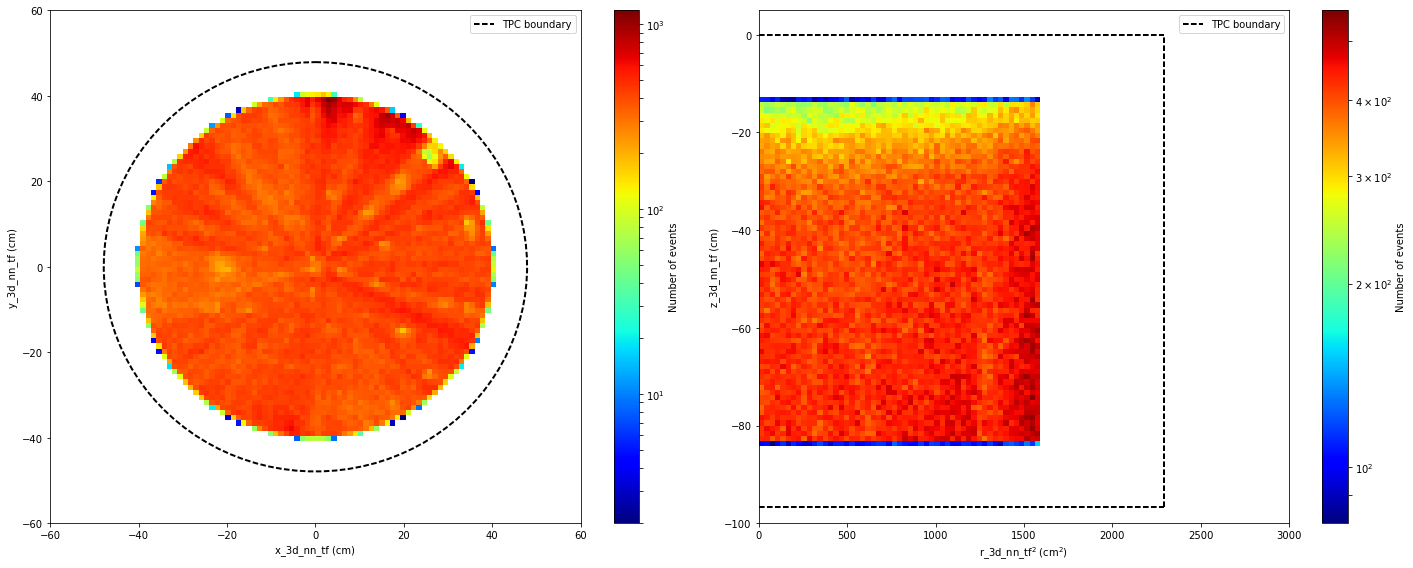

In [19]:
data_distribution(data, 'x_3d_nn_tf', 'y_3d_nn_tf', 'z_3d_nn_tf', 'r_3d_nn_tf', bins=[100,100])

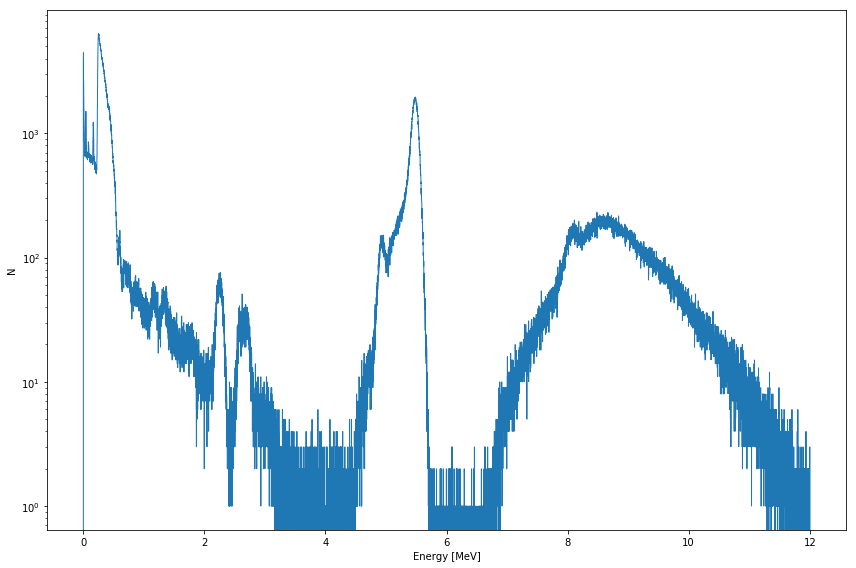

In [20]:
plt.figure(figsize=(12,8))
plt.hist(data['CES']/10**6, bins = (10000), 
         range=(0, 12), 
         histtype='step')
plt.xlabel('Energy [MeV]')
plt.ylabel('N')
plt.yscale('log')

plt.tight_layout()
plt.show()

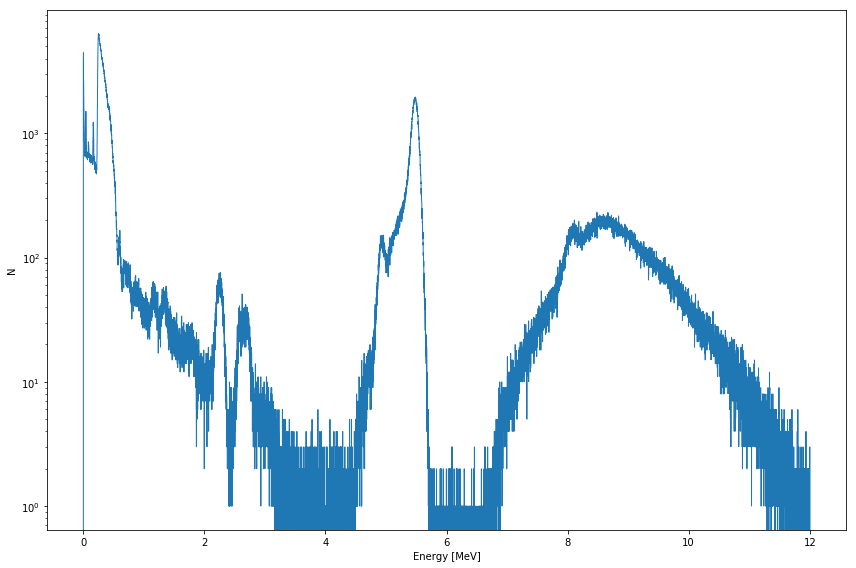

In [21]:
plt.figure(figsize=(12,8))
plt.hist(data['CES']/10**6, bins = (10000), 
         range=(0, 12), 
         histtype='step')
plt.xlabel('Energy [MeV]')
plt.ylabel('N')
plt.yscale('log')

plt.tight_layout()
plt.show()

- /project/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/data_cut_new_SR1_S1PL.pkl -> Data sample after pre-selection cuts

In [22]:
data.to_pickle('/project/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/data_cut_new_SR1_S1PL.pkl')